### 0. Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn preprocessing and scaling
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Dimensionality reduction and clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
import networkx as nx

# Custom modules for visualization
from dimensionality_visaul import visual_dim

# Settings
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

### 1. 함수

In [8]:
def youtube_search_link(query):
    import urllib.parse
    base_url = "https://www.youtube.com/results?search_query="
    search_query = urllib.parse.quote(query)  # 검색어 인코딩
    return base_url + search_query

In [9]:
def label_visual(dataframe):
    # 박스플롯을 그릴 열 개수에 맞춰 서브플롯을 설정
    n_cols = len(dataframe.columns) - 1  # 'label' 제외한 열 개수
    n_rows = (n_cols // 3) + (1 if n_cols % 3 != 0 else 0)  # 3열로 배치되도록 행 수 계산

    # 서브플롯을 생성
    fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5*n_rows))

    # 서브플롯을 평평한 배열로 변환
    axes = axes.flatten()

    # 각 열에 대해 박스플롯 또는 막대 그래프를 그리기
    for i, col in enumerate(dataframe.columns[:-1]):  # 마지막 'label' 제외
        if dataframe[col].dtype == 'object' or dataframe[col].nunique() <= 12:
            # 범주형 변수일 경우, 막대 그래프 (countplot) 사용
            sns.countplot(data=dataframe, x=col, ax=axes[i], hue='label', palette='Set2')
        else:
            # 연속형 변수일 경우, 박스플롯 (boxplot) 사용
            sns.boxplot(data=dataframe, x='label', y=col, ax=axes[i])

        axes[i].set_title(f'{col}')

    # 여분의 서브플롯을 숨기기
    for i in range(n_cols, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()  # 서브플롯 간 간격 조정
    plt.show()

In [10]:
def hyperparms_visaul(silhouette_scores, ch_scores, db_scores, strat, end):
    # 최적의 k 값 찾기
    print(f"Silhouette Score Optimal number of clusters: {np.argmax(silhouette_scores) + strat}")
    print(f"ch_score Optimal number of clusters: {np.argmax(ch_scores) + strat}")
    print(f"db_score Optimal number of clusters: {np.argmin(db_scores) + strat}")

    # 결과 시각화
    plt.figure(figsize=(12, 4))

    # Silhouette Score
    plt.subplot(1, 3, 1)
    plt.plot(range(strat, end), silhouette_scores, marker='o', label="Silhouette Score")
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.grid()
    plt.legend()

    # Calinski-Harabasz Score
    plt.subplot(1, 3, 2)
    plt.plot(range(strat, end), ch_scores, marker='o', color='g', label="Calinski-Harabasz Score")
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('CH Score')
    plt.title('Calinski-Harabasz Score')
    plt.grid()
    plt.legend()

    # Davies-Bouldin Score
    plt.subplot(1, 3, 3)
    plt.plot(range(strat, end), db_scores, marker='o', color='r', label="Davies-Bouldin Score")
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('DB Score')
    plt.title('Davies-Bouldin Score (Lower is Better)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def compute_knn_similarity_matrix(X, k=10):
    """KNN 유사도 행렬 계산"""
    knn_graph = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=True)
    return knn_graph.toarray()  # sparse matrix를 dense array로 변환

def calculate_conductance(G, community):
    """전도성(Conductance) 계산"""
    cut_size = 0
    volume = 0
    for node in community:
        neighbors = list(G.neighbors(node))
        volume += len(neighbors)
        cut_size += sum([1 for neighbor in neighbors if neighbor not in community])
    
    return 0 if volume == 0 else cut_size / volume

def spectral_clustering_analysis(X, k_range=(3, 11), n_neighbors=10):
    modularity_scores = []
    conductance_scores = []
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    
    for k in range(k_range[0], k_range[1]):
        # Spectral Clustering 적용
        spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=n_neighbors, random_state=42)
        labels = spectral.fit_predict(X)

        # 유사도 행렬 계산
        similarity_matrix = compute_knn_similarity_matrix(X, k=n_neighbors)
        
        # 그래프 생성
        G = nx.from_numpy_array(similarity_matrix)

        # 클러스터별 노드 그룹화
        communities = {i: [] for i in range(k)}
        for node, cluster in enumerate(labels):
            communities[cluster].append(node)
        
        # 모듈러리티 계산
        modularity_score = nx.community.modularity(G, list(communities.values()))
        modularity_scores.append(modularity_score)

        # 전도성 계산
        total_conductance = np.mean([calculate_conductance(G, set(nodes)) for nodes in communities.values()])
        conductance_scores.append(total_conductance)

        # 추가 군집 평가 지표 계산
        silhouette_scores.append(silhouette_score(X, labels))
        ch_scores.append(calinski_harabasz_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))

        print(f"k={k}, Modularity={modularity_score:.4f}, Conductance={total_conductance:.4f}, "
              f"Silhouette={silhouette_scores[-1]:.4f}, CH={ch_scores[-1]:.2f}, DB={db_scores[-1]:.4f}")

    return modularity_scores, conductance_scores, silhouette_scores, ch_scores, db_scores

### 2. Data

In [12]:
df = pd.read_csv(r'data\data.csv')
print(df.shape)
df.head(3)

(170653, 19)


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


#### 2.1 EDA

In [13]:
# 결측치 없음
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

#### 2.2 중복값 확인

In [14]:
df[['name', 'artists']].duplicated().sum()

12968

In [15]:
# 중복 제거 한 데이터 프레임
unique_indices = df[['name', 'artists']].drop_duplicates().index
df = df.loc[unique_indices]
print(df.shape)

(157685, 19)


#### 2.3 Columns

##### 2.3.1 valence

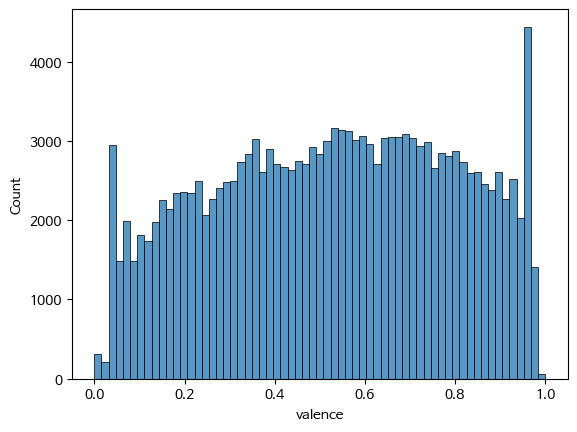

count    157685.000000
mean          0.527579
std           0.263225
min           0.000000
25%           0.316000
50%           0.538000
75%           0.746000
max           1.000000
Name: valence, dtype: float64


In [16]:
# valence histgram
sns.histplot(data = df, x = 'valence')
plt.show()
print(df['valence'].describe())

##### 2.3.2 year

In [17]:
df['year'].value_counts()[:5]

2018    2040
2017    1929
1950    1927
1940    1917
1968    1908
Name: year, dtype: int64

In [18]:
print(f"2000년 이상 : {df[df['year'] >= 2000].shape[0]}")
print(f"2010년 이상 : {df[df['year'] >= 2010].shape[0]}")

2000년 이상 : 37922
2010년 이상 : 20282


##### 2.3.3 acoustincness

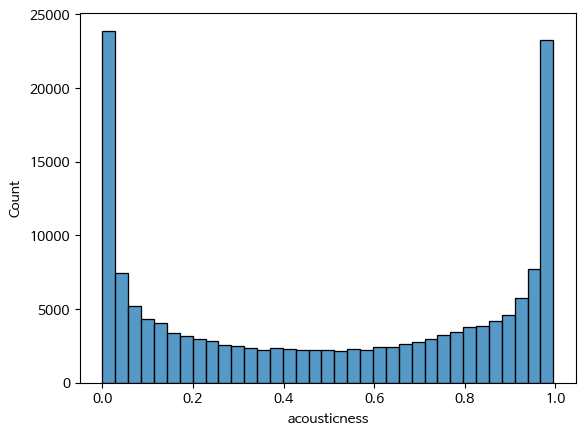

count    157685.000000
mean          0.504277
std           0.376070
min           0.000000
25%           0.103000
50%           0.522000
75%           0.894000
max           0.996000
Name: acousticness, dtype: float64


In [19]:
# acousticness histgram
sns.histplot(data = df, x = 'acousticness')
plt.show()
print(df['acousticness'].describe())

##### 2.3.4 Danceability

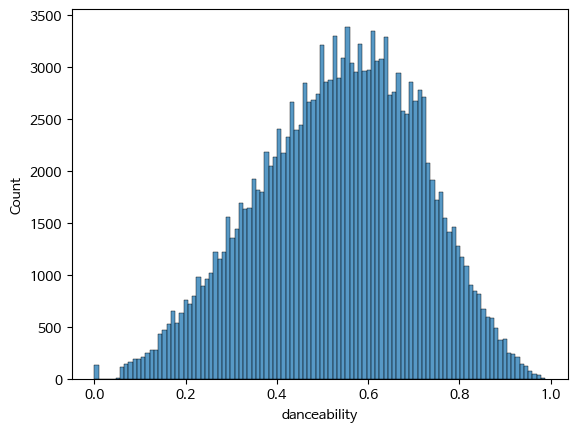

count    157685.000000
mean          0.536762
std           0.176398
min           0.000000
25%           0.414000
50%           0.547000
75%           0.668000
max           0.988000
Name: danceability, dtype: float64


In [20]:
# danceability histgram
sns.histplot(data = df, x = 'danceability')
plt.show()
print(df['danceability'].describe())

##### 2.3.5 duration_ms

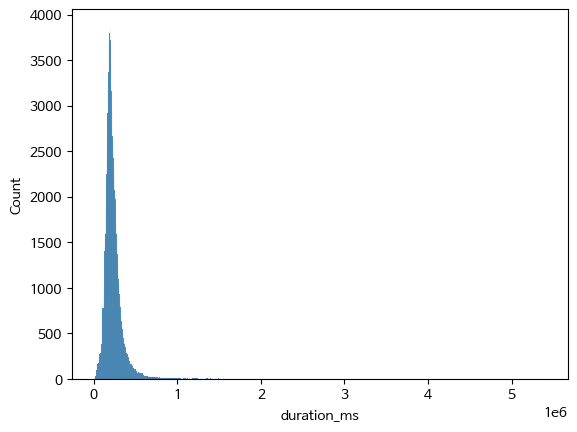

count    1.576850e+05
mean     2.305950e+05
std      1.264735e+05
min      5.108000e+03
25%      1.694000e+05
50%      2.069470e+05
75%      2.621730e+05
max      5.403500e+06
Name: duration_ms, dtype: float64


In [21]:
# Duration_ms histgram
sns.histplot(data = df, x = 'duration_ms')
plt.show()
print(df['duration_ms'].describe())

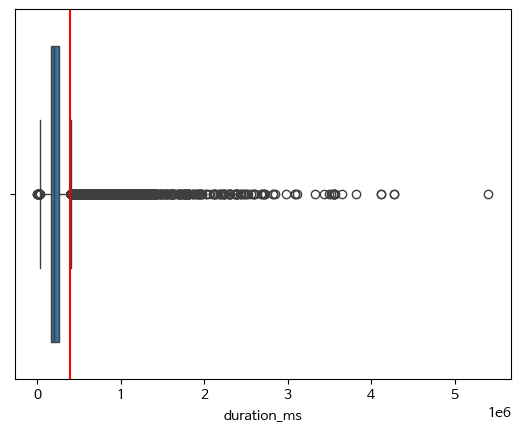

In [22]:
# 1.5 * IQR 이상 제거
sns.boxplot(data = df, x = 'duration_ms')
plt.axvline(x = 0.4e+06, color = 'r')
plt.show()

##### 2.3.6 energy

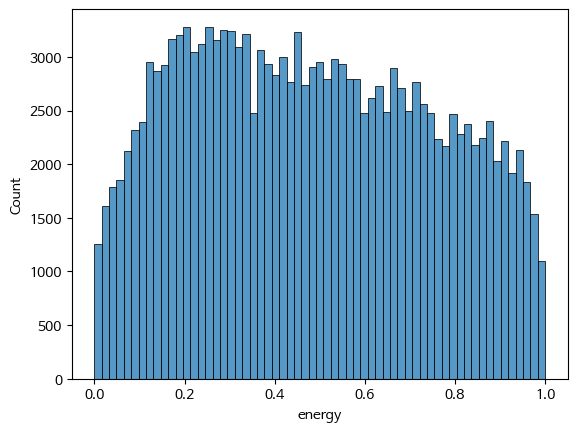

count    157685.000000
mean          0.480694
std           0.267640
min           0.000000
25%           0.254000
50%           0.468000
75%           0.701000
max           1.000000
Name: energy, dtype: float64


In [23]:
# energy histgram
sns.histplot(data = df, x = 'energy')
plt.show()
print(df['energy'].describe())

##### 2.3.7 explicit

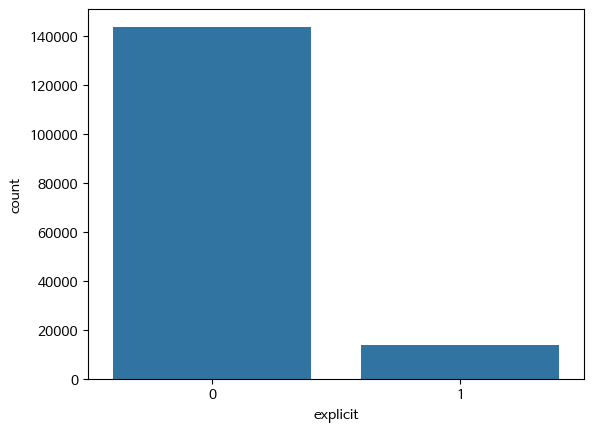

In [24]:
# explicit histgram
# 제거
sns.countplot(data = df, x = 'explicit')
plt.show()

##### 2.3.8 instrumentalness

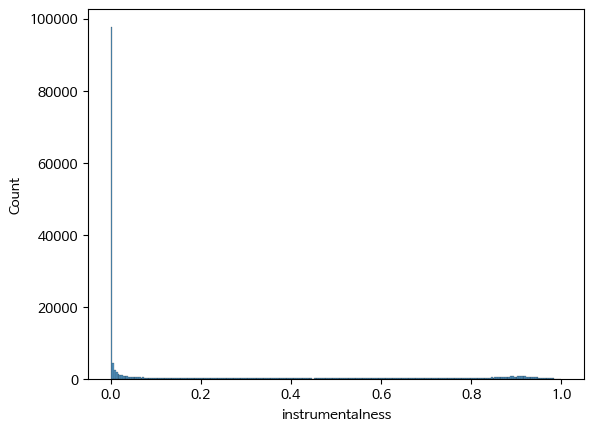

count    157685.000000
mean          0.167909
std           0.313854
min           0.000000
25%           0.000000
50%           0.000224
75%           0.106000
max           1.000000
Name: instrumentalness, dtype: float64


In [25]:
# instrumentalness histgram
# 매우 치우쳐진 분포
sns.histplot(data = df, x = 'instrumentalness')
plt.show()
print(df['instrumentalness'].describe())

##### 2.3.9 key

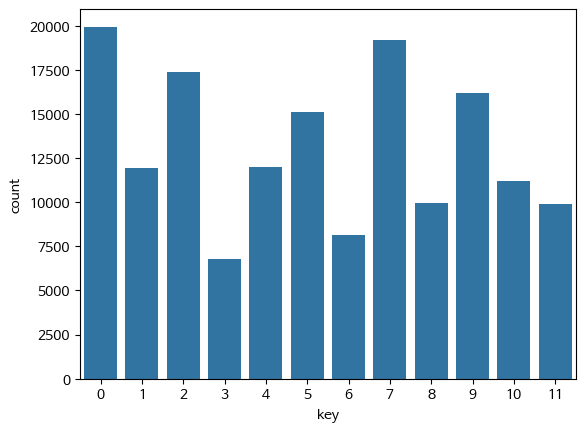

In [26]:
# explicit histgram
sns.countplot(data = df, x = 'key')
plt.show()

##### 2.3.10 liveness

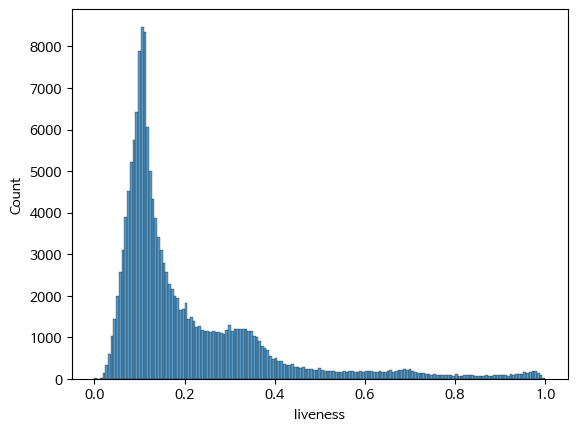

count    157685.000000
mean          0.206755
std           0.175506
min           0.000000
25%           0.099000
50%           0.136000
75%           0.263000
max           1.000000
Name: liveness, dtype: float64


In [27]:
# liveness histgram
sns.histplot(data = df, x = 'liveness')
plt.show()
print(df['liveness'].describe())

##### 2.3.11 loudness

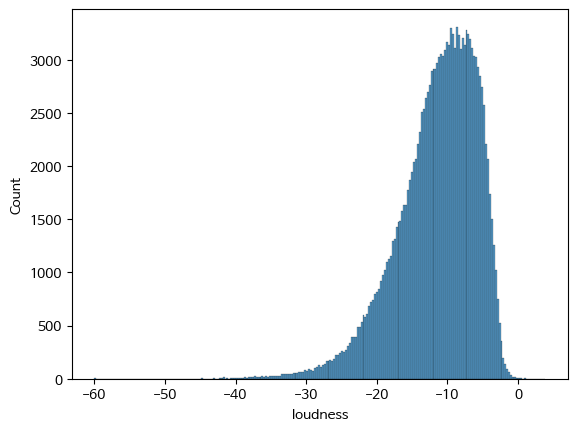

count    157685.000000
mean        -11.502779
std           5.699130
min         -60.000000
25%         -14.669000
50%         -10.618000
75%          -7.210000
max           3.855000
Name: loudness, dtype: float64


In [28]:
# loudness histgram
# scale 필요해보임
sns.histplot(data = df, x = 'loudness')
plt.show()
print(df['loudness'].describe())

##### 2.3.12 mode

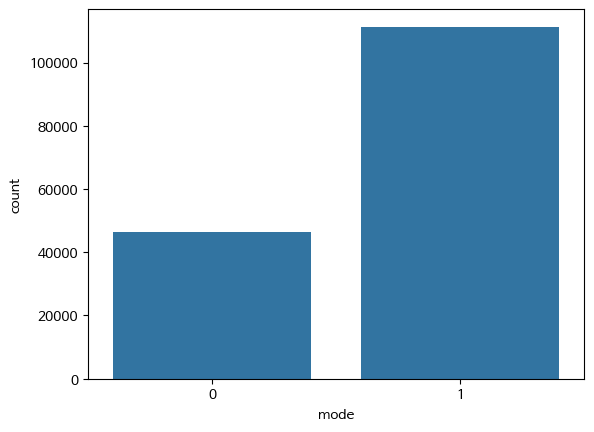

In [29]:
# explicit histgram
sns.countplot(data = df, x = 'mode')
plt.show()

##### 2.3.13 popularity

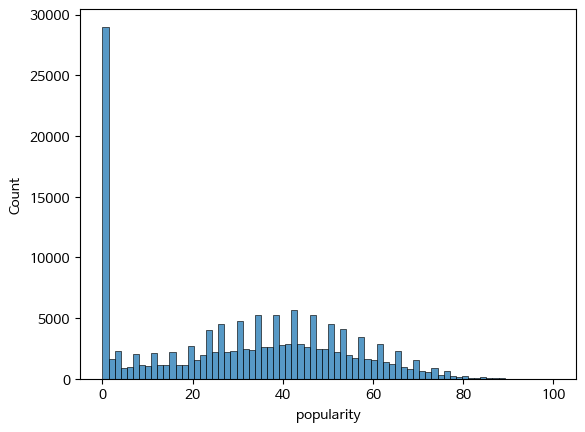

count    157685.000000
mean         31.445845
std          21.957673
min           0.000000
25%          11.000000
50%          34.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64


In [30]:
# popularity histgram
sns.histplot(data = df, x = 'popularity')
plt.show()
print(df['popularity'].describe())

##### 2.3.14 speechiness

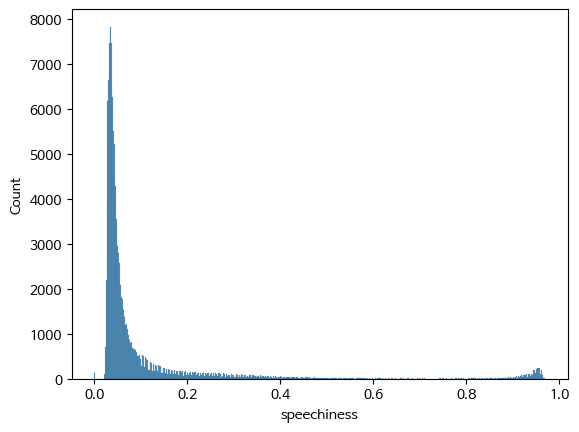

count    157685.000000
mean          0.100937
std           0.167698
min           0.000000
25%           0.035000
50%           0.045300
75%           0.077000
max           0.970000
Name: speechiness, dtype: float64


In [31]:
# speechiness histgram
sns.histplot(data = df, x = 'speechiness')
plt.show()
print(df['speechiness'].describe())

##### 2.3.15 tempo

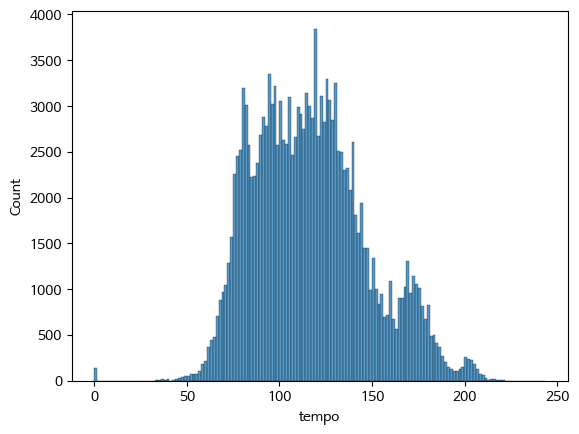

count    157685.000000
mean        116.799153
std          30.754080
min           0.000000
25%          93.240000
50%         114.726000
75%         135.519000
max         243.507000
Name: tempo, dtype: float64


In [32]:
# tempo histgram
# scale 필요
sns.histplot(data = df, x = 'tempo')
plt.show()
print(df['tempo'].describe())

#### 2.4 Data Processing

In [33]:
# 그나마 최신곡
cond1 = (df['year'] >= 2010) # 2010년 발행한 음악한 취급
cond2 = (df['duration_ms'] <= 0.4e+06) # 너무 긴 음악 제거
cond3 = (df['popularity'] >= 60) # 인기도 60 이상

df = df[cond1 & cond2 & cond3]
print(df.shape)
df.head()

(10428, 19)


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
17606,0.434,2010,0.01510,['Bruno Mars'],0.637,220733,0.843,0,7BqBn9nzAq8spo5e7cZ0dJ,0.000000,5,0.0876,-5.413,1,Just the Way You Are,81,2010-10-05,0.0432,109.012
17607,0.795,2010,0.18500,['Train'],0.673,216773,0.886,0,4HlFJV71xXKIGcU3kRyttv,0.000000,1,0.0826,-4.440,0,"Hey, Soul Sister",83,2010-12-01,0.0431,97.012
17608,0.361,2010,0.00544,"['Waka Flocka Flame', 'Roscoe Dash', 'Wale']",0.760,263773,0.595,1,03tqyYWC9Um2ZqU0ZN849H,0.000000,1,0.2410,-6.366,1,No Hands (feat. Roscoe Dash & Wale),76,2010-10-01,0.0391,131.497
17609,0.504,2010,0.02750,['Miguel'],0.684,195373,0.603,0,0JXXNGljqupsJaZsgSbMZV,0.000311,11,0.1910,-8.127,0,Sure Thing,78,2010-11-26,0.0989,81.000
17610,0.065,2010,0.51200,['Bruno Mars'],0.523,217867,0.606,0,161DnLWsx1i3u1JT05lzqU,0.000000,1,0.1060,-4.754,0,Talking to the Moon,77,2010-10-05,0.0301,145.837


#### 2.5 노래 특성 데이터프레임

In [34]:
# 노래 특성 테이블
df_features = df.drop(
    columns = {'id', 'year', 'release_date', 'name', 'artists', 'popularity', 'duration_ms', 'explicit'}).reset_index(drop=True)
print(df_features.shape)
df_features.head()

(10428, 11)


,valence,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,0.434,0.01510,0.637,0.843,0.000000,5,0.0876,-5.413,1,0.0432,109.012
1,0.795,0.18500,0.673,0.886,0.000000,1,0.0826,-4.440,0,0.0431,97.012
2,0.361,0.00544,0.760,0.595,0.000000,1,0.2410,-6.366,1,0.0391,131.497
3,0.504,0.02750,0.684,0.603,0.000311,11,0.1910,-8.127,0,0.0989,81.000
4,0.065,0.51200,0.523,0.606,0.000000,1,0.1060,-4.754,0,0.0301,145.837


#### 2.6 노래 정보 데이터프레임

In [35]:
# 노래 정보 테이블
df_idx = df[['id', 'year', 'release_date', 'name', 'artists', 'popularity']].reset_index(drop=True)
df_idx['artists'] = df_idx['artists'].apply(lambda x: eval(x)[0] if x.startswith('[') else x)
df_idx['youtube'] = df_idx['name'] + ' ' + df_idx['artists']
df_idx['youtube'] = df_idx['youtube'].map(youtube_search_link)
df_idx.head()

,id,year,release_date,name,artists,popularity,youtube
0,7BqBn9nzAq8spo5e7cZ0dJ,2010,2010-10-05,Just the Way You Are,Bruno Mars,81,https://www.youtube.com/results?search_query=J...
1,4HlFJV71xXKIGcU3kRyttv,2010,2010-12-01,"Hey, Soul Sister",Train,83,https://www.youtube.com/results?search_query=H...
2,03tqyYWC9Um2ZqU0ZN849H,2010,2010-10-01,No Hands (feat. Roscoe Dash & Wale),Waka Flocka Flame,76,https://www.youtube.com/results?search_query=N...
3,0JXXNGljqupsJaZsgSbMZV,2010,2010-11-26,Sure Thing,Miguel,78,https://www.youtube.com/results?search_query=S...
4,161DnLWsx1i3u1JT05lzqU,2010,2010-10-05,Talking to the Moon,Bruno Mars,77,https://www.youtube.com/results?search_query=T...


#### 2.7 Data Transform

In [36]:
df_features.columns

Index(['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo'],
      dtype='object')

In [37]:
# 범주형과 연속형 변수 구분
categorical_features = ['key']
binary_features = ['mode']
continuous_features = ['valence', 'acousticness', 'danceability', 'energy', 
                       'instrumentalness', 'loudness', 'speechiness', 'tempo']

# ColumnTransformer로 처리
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),  
        ('bin', 'passthrough', binary_features),          
        ('num', StandardScaler(), continuous_features)    
    ]
)

# 변환
processed_data = preprocessor.fit_transform(df_features)

# 변환된 데이터 확인
print(processed_data.shape)

(10428, 21)


#### 2.8 차원축소

Selected number of components: 9


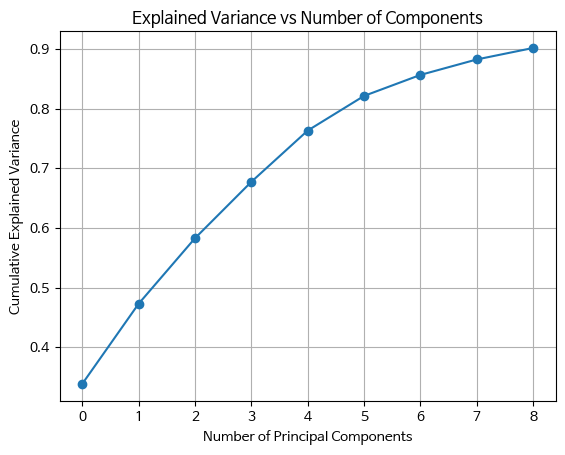

In [38]:
# PCA 적용 (설명된 분산이 90% 이상 유지되도록)
pca = PCA(n_components=0.9)  
scaled_data_pca = pca.fit_transform(processed_data)

# 주성분 개수 출력
print(f"Selected number of components: {scaled_data_pca.shape[1]}")

# 설명된 분산 비율 시각화
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.grid()
plt.show()

### 3. Modeling

#### 3.1 SpectralClustering KNN

Silhouette Score Optimal number of clusters: 8
ch_score Optimal number of clusters: 8
db_score Optimal number of clusters: 9


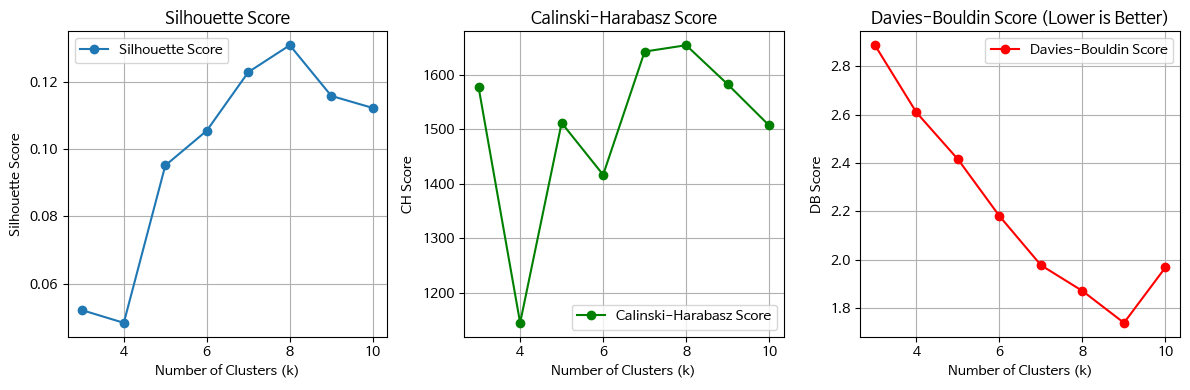

In [39]:
# 클러스터링 평가 지표 저장 리스트
silhouette_scores = []
ch_scores = []
db_scores = []

start_k = 3
end_k = 11

# 5~10개의 클러스터 개수에 대해 성능 평가
for k in range(start_k, end_k):
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        n_neighbors=10,  # 유사도 행렬을 사용
        random_state=42
    )
    
    # 유사도 행렬로 클러스터링을 수행
    labels = spectral.fit_predict(scaled_data_pca)

    # 평가 지표 계산
    silhouette = silhouette_score(scaled_data_pca, labels)
    ch_score = calinski_harabasz_score(scaled_data_pca, labels)
    db_score = davies_bouldin_score(scaled_data_pca, labels)

    silhouette_scores.append(silhouette)
    ch_scores.append(ch_score)
    db_scores.append(db_score)

# 평가 결과 시각화
hyperparms_visaul(silhouette_scores, ch_scores, db_scores, start_k, end_k)

k=3, Modularity=0.4653, Conductance=0.0254, Silhouette=0.0521, CH=1577.00, DB=2.8882
k=4, Modularity=0.4651, Conductance=0.0338, Silhouette=0.0483, CH=1144.21, DB=2.6094
k=5, Modularity=0.6046, Conductance=0.0442, Silhouette=0.0951, CH=1511.94, DB=2.4153
k=6, Modularity=0.6083, Conductance=0.0505, Silhouette=0.1055, CH=1416.44, DB=2.1802
k=7, Modularity=0.6898, Conductance=0.0596, Silhouette=0.1229, CH=1643.03, DB=1.9766
k=8, Modularity=0.7348, Conductance=0.0709, Silhouette=0.1309, CH=1654.75, DB=1.8700
k=9, Modularity=0.7564, Conductance=0.0788, Silhouette=0.1158, CH=1582.94, DB=1.7379
k=10, Modularity=0.7772, Conductance=0.0837, Silhouette=0.1122, CH=1507.17, DB=1.9678


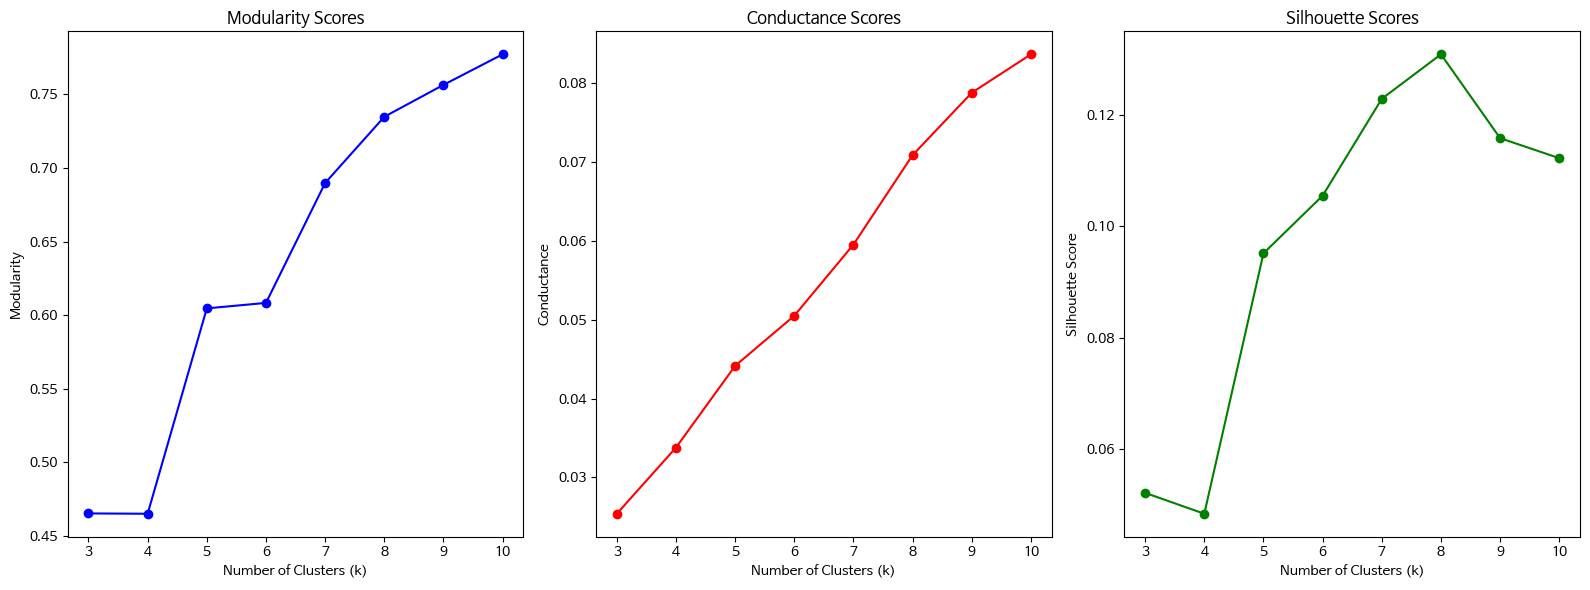

In [40]:
# 실행
modularity_scores, conductance_scores, silhouette_scores, ch_scores, db_scores = spectral_clustering_analysis(
    scaled_data_pca, k_range=(3, 11), n_neighbors=10)

# 결과 시각화
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.plot(range(3, 11), modularity_scores, marker='o', color='b', label='Modularity')
plt.title('Modularity Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Modularity')

plt.subplot(1, 3, 2)
plt.plot(range(3, 11), conductance_scores, marker='o', color='r', label='Conductance')
plt.title('Conductance Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Conductance')

plt.subplot(1, 3, 3)
plt.plot(range(3, 11), silhouette_scores, marker='o', color='g', label='Silhouette Score')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [41]:
spectral = SpectralClustering(
        n_clusters=8,        
        affinity='nearest_neighbors',
        n_neighbors=10,
        random_state=42
    )
labels = spectral.fit_predict(scaled_data_pca)
df_features['label'] = labels
df_idx['label'] = labels
df_idx.to_csv('SpectralClustering_Song.csv', index=False)
df_features['label'].value_counts()

1    2781
2    2524
5    1683
0    1482
7    1323
4     344
6     173
3     118
Name: label, dtype: int64

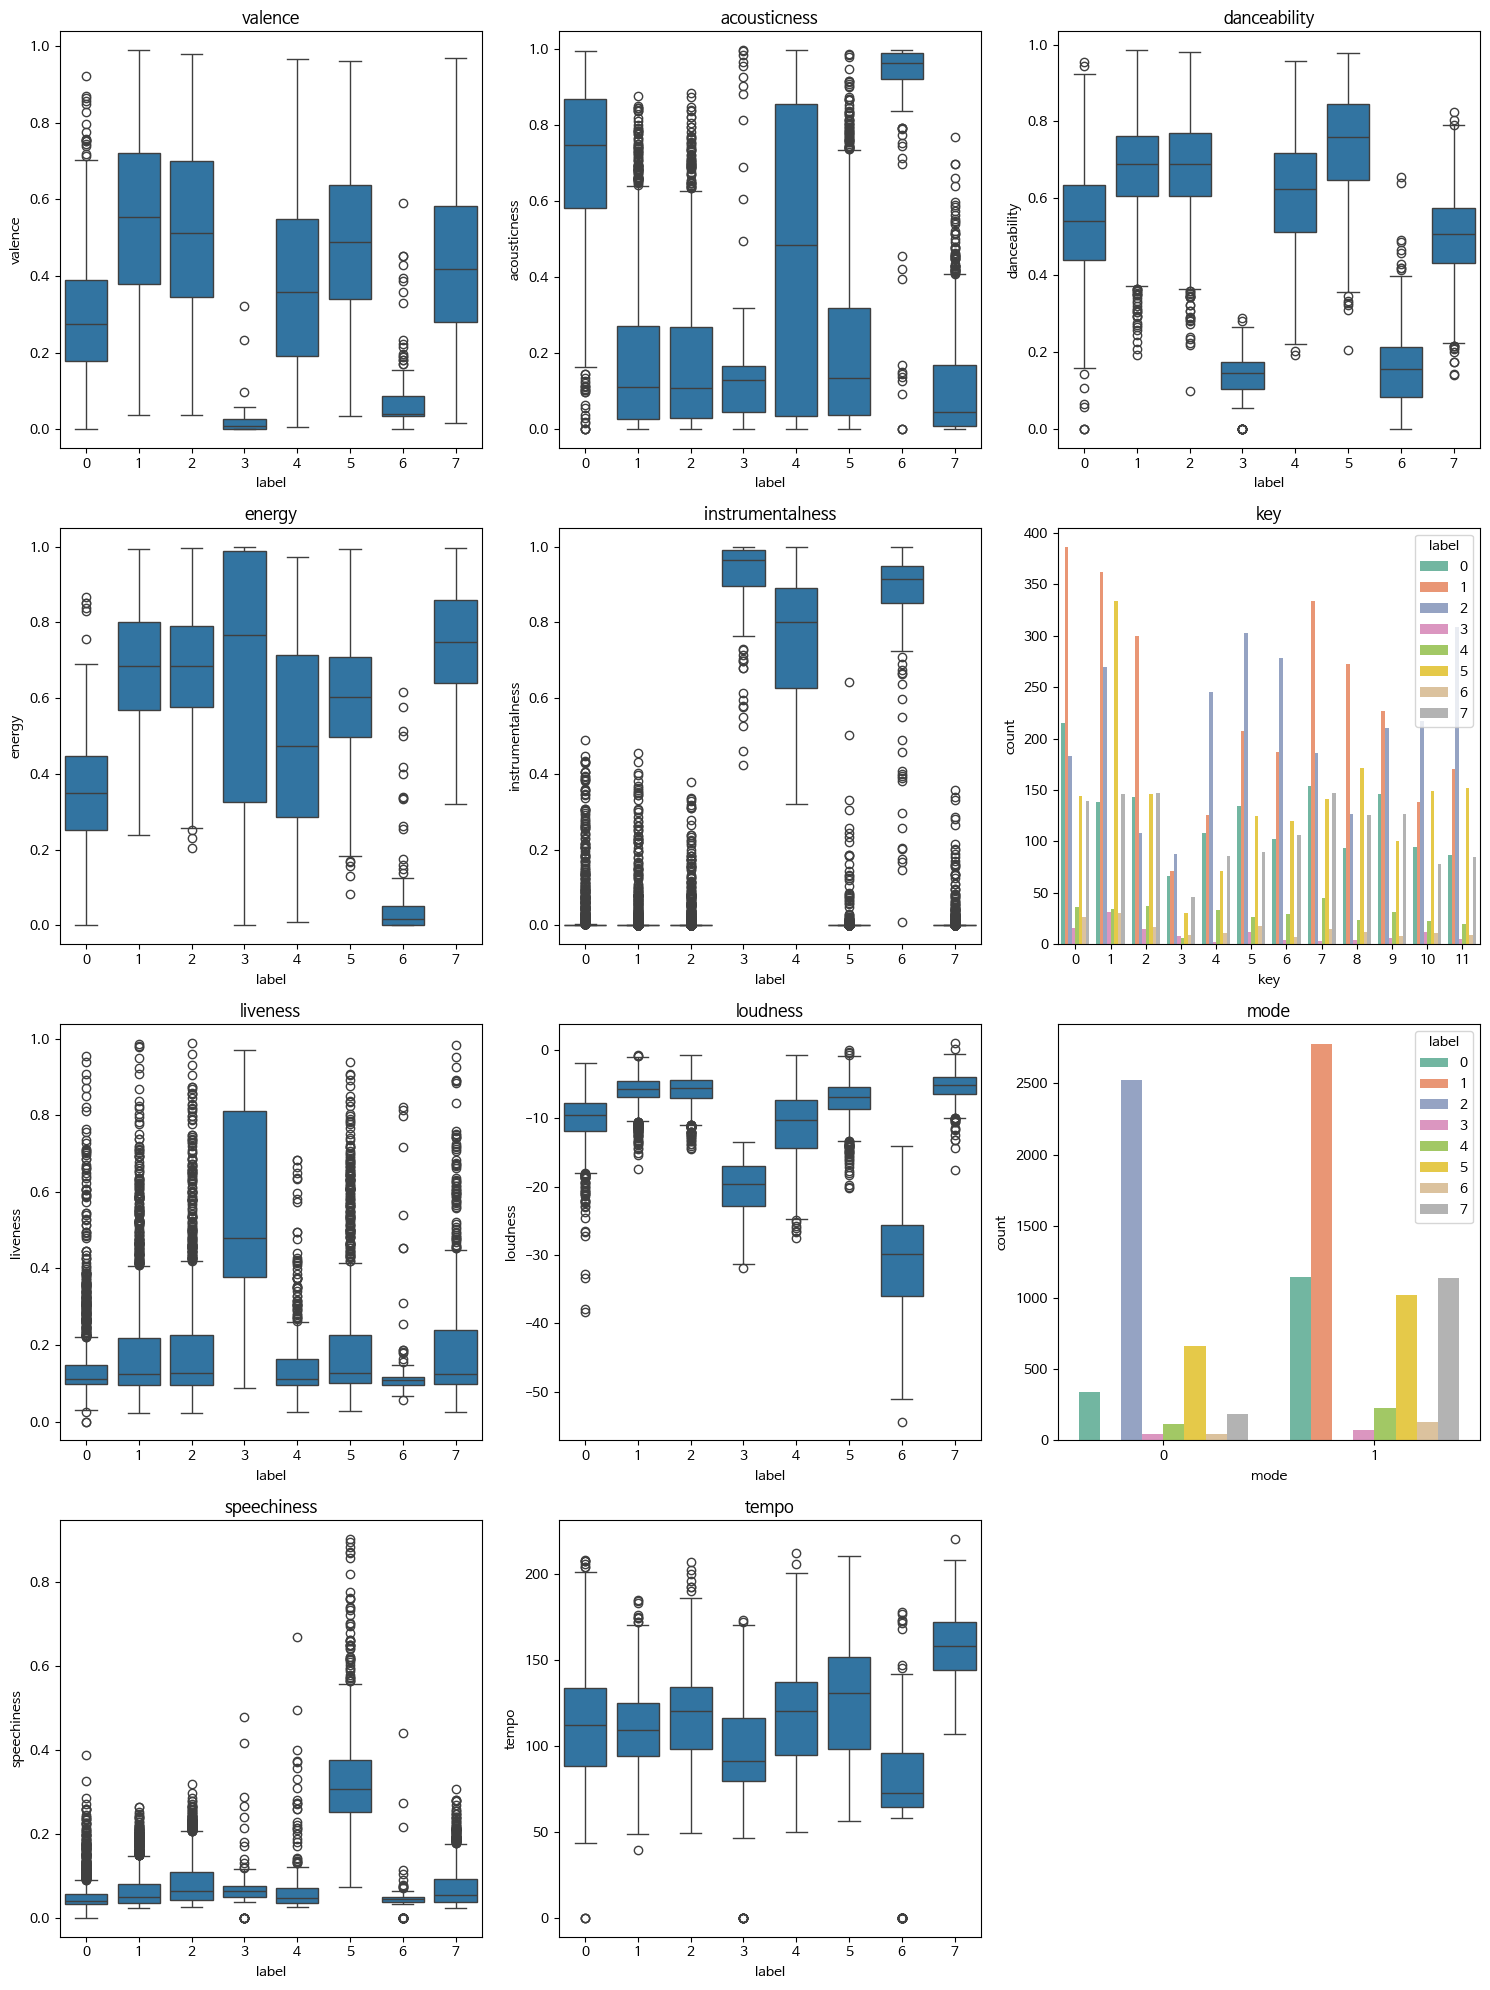

In [42]:
label_visual(df_features)


PCA Explained Variance: [0.33815731 0.13445469 0.10995236]


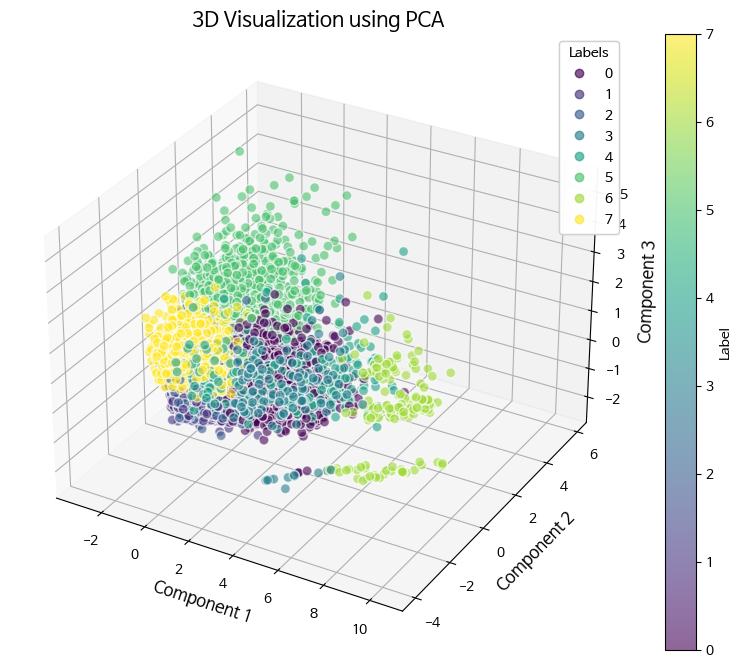

In [43]:
visual_dim(df_features, 'PCA', categorical_features, binary_features, continuous_features)

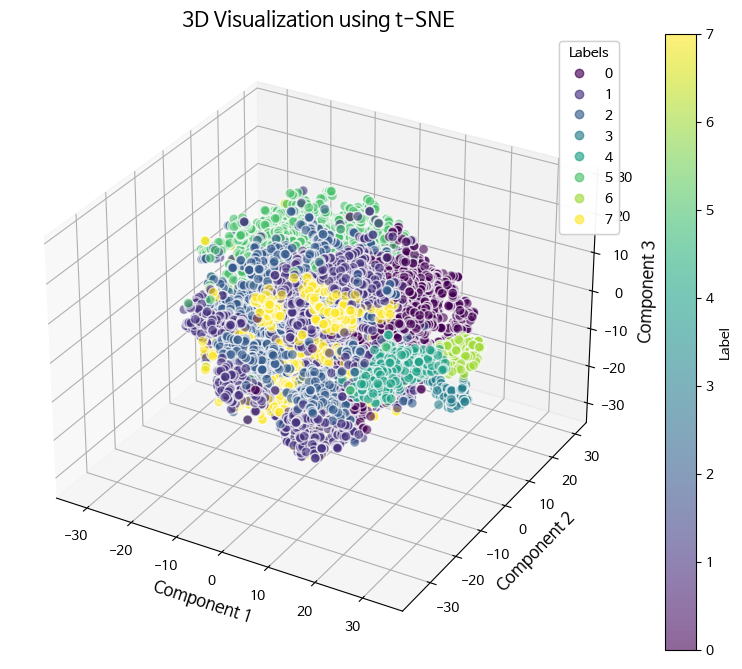

In [44]:
visual_dim(df_features, 't-SNE', categorical_features, binary_features, continuous_features)

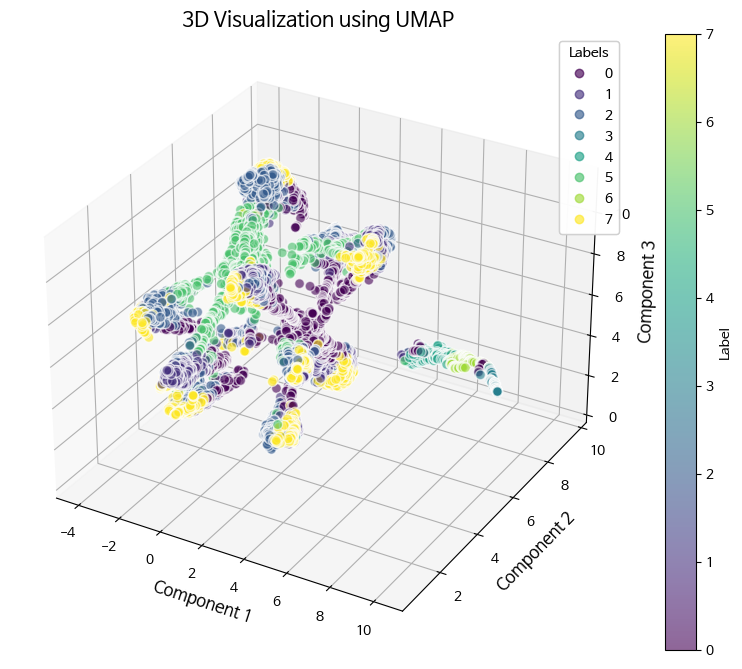

In [45]:
visual_dim(df_features, 'UMAP', categorical_features, binary_features, continuous_features)

### 4. Result

In [50]:
df_features.to_csv('SpectralClustering_Song_features.csv', index=False)

In [53]:
result_features = pd.read_csv('SpectralClustering_Song_features.csv')
result_Song = pd.read_csv('SpectralClustering_Song.csv')

In [52]:
result_features.head()

,valence,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,label
0,0.434,0.01510,0.637,0.843,0.000000,5,0.0876,-5.413,1,0.0432,109.012,1
1,0.795,0.18500,0.673,0.886,0.000000,1,0.0826,-4.440,0,0.0431,97.012,2
2,0.361,0.00544,0.760,0.595,0.000000,1,0.2410,-6.366,1,0.0391,131.497,1
3,0.504,0.02750,0.684,0.603,0.000311,11,0.1910,-8.127,0,0.0989,81.000,2
4,0.065,0.51200,0.523,0.606,0.000000,1,0.1060,-4.754,0,0.0301,145.837,0


In [54]:
result_Song.head()

,id,year,release_date,name,artists,popularity,youtube,label
0,7BqBn9nzAq8spo5e7cZ0dJ,2010,2010-10-05,Just the Way You Are,Bruno Mars,81,https://www.youtube.com/results?search_query=J...,1
1,4HlFJV71xXKIGcU3kRyttv,2010,2010-12-01,"Hey, Soul Sister",Train,83,https://www.youtube.com/results?search_query=H...,2
2,03tqyYWC9Um2ZqU0ZN849H,2010,2010-10-01,No Hands (feat. Roscoe Dash & Wale),Waka Flocka Flame,76,https://www.youtube.com/results?search_query=N...,1
3,0JXXNGljqupsJaZsgSbMZV,2010,2010-11-26,Sure Thing,Miguel,78,https://www.youtube.com/results?search_query=S...,2
4,161DnLWsx1i3u1JT05lzqU,2010,2010-10-05,Talking to the Moon,Bruno Mars,77,https://www.youtube.com/results?search_query=T...,0
